In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf


import seaborn as sns
import warnings
import os
from scipy.interpolate import griddata



from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras import datasets, layers, models
from tensorflow import keras
from keras.callbacks import ModelCheckpoint


from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

import meshio
import re

In [2]:
import cfdnetplus

In [24]:
path_to_main= 'airfoil2d/'
folders=['airFoil_1000', 'airFoil_30', 'airFoil_300','airFoil_600', 'airFoil_3000', 'airFoil_2000']
fields= ['U','p']
xlim =[-50,50]
ylim = [-30 , 30]
xres=256
yres=66
zcut=0.05
modelid='model_Up'

In [5]:
cfdnetplus.VTK2np(path_to_main,folders, fields,'xy' ,xres,yres,xlim,ylim,zcut)

processing data in airfoil2d/airFoil_1000/VTK/
(339, 66, 256, 4)
339
[266]
data written toairfoil2d/airFoil_1000/VTK/df
processing data in airfoil2d/airFoil_30/VTK/
(600, 66, 256, 4)
600
[555]
data written toairfoil2d/airFoil_30/VTK/df
processing data in airfoil2d/airFoil_300/VTK/
(338, 66, 256, 4)
338
[265]
data written toairfoil2d/airFoil_300/VTK/df
processing data in airfoil2d/airFoil_600/VTK/
(338, 66, 256, 4)
338
[265]
data written toairfoil2d/airFoil_600/VTK/df
processing data in airfoil2d/airFoil_3000/VTK/
(340, 66, 256, 4)
340
[267]
data written toairfoil2d/airFoil_3000/VTK/df
processing data in airfoil2d/airFoil_2000/VTK/
(340, 66, 256, 4)
340
[267]
data written toairfoil2d/airFoil_2000/VTK/df


['airfoil2d/airFoil_1000/VTK/',
 'airfoil2d/airFoil_30/VTK/',
 'airfoil2d/airFoil_300/VTK/',
 'airfoil2d/airFoil_600/VTK/',
 'airfoil2d/airFoil_3000/VTK/',
 'airfoil2d/airFoil_2000/VTK/']

In [25]:
if 'U' in fields:
    l=len(fields)+2
else:
    l=len(fields)

df = np.empty((0,66,256,l))
df_label = np.empty((0,66,256,l))
path_to_folders=[]
for i in folders:
    path_to_folders.append(path_to_main+i+'/VTK/')
    df_t=np.load(path_to_main+i+'/VTK/df.npy')
    df_tlabel=np.load(path_to_main+i+'/VTK/df_label.npy')
    df=np.concatenate((df,df_t))
    df_label=np.concatenate((df_label,df_tlabel))
df=df[:,:,:,[0,1,3]]
df_label=df_label[:,:,:,[0,1,3]]
print(df_label.shape)

(2295, 66, 256, 3)


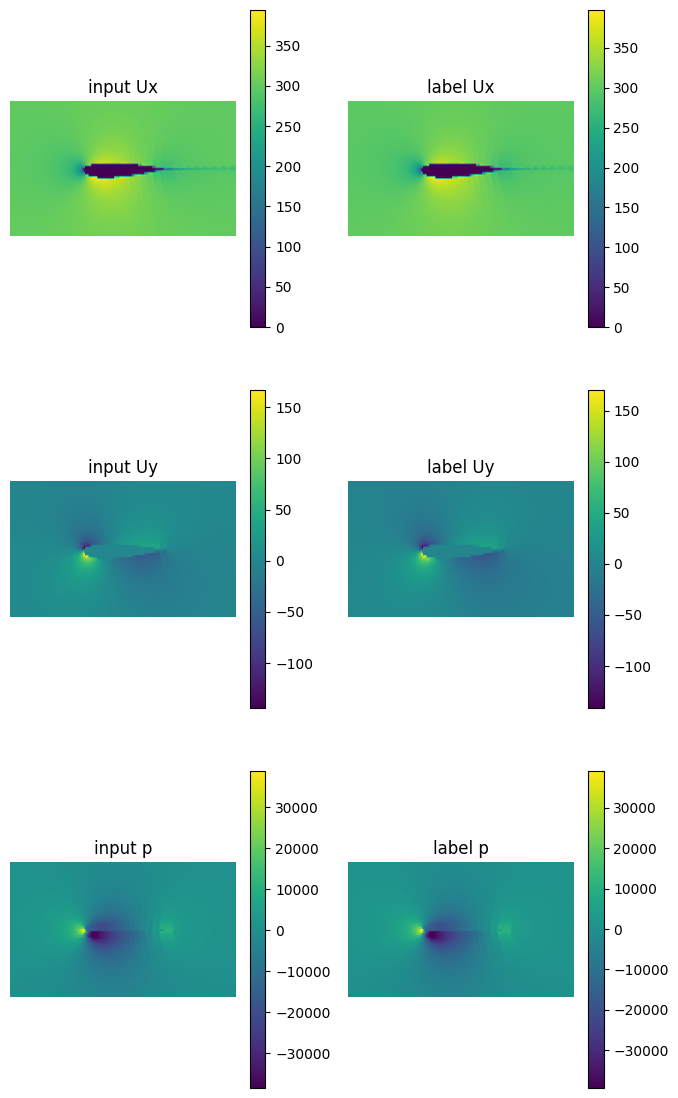

In [26]:

n=1000
fig = plt.figure(figsize=(8, 14))
[a,b,c,d]=df.shape
titles= ['Ux','Uy','p']

for i in range(d):
    fig.add_subplot(d, 2, i*2+1)
    plt.imshow(df[n,:,:,i],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
    plt.title('input ' +titles[i])
    plt.axis('off')
    plt.colorbar()
    
    fig.add_subplot(d, 2, i*2+2)
    plt.imshow(df_label[n,:,:,i],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
    plt.title('label '+titles[i])
    plt.axis('off')
    plt.colorbar()
    #print(i)

plt.show()

In [27]:
#normalise U Vektors

p_max=np.max(abs(df[:,:,:,[2]]))
U_max=np.max(abs(df[:,:,:,[0,1,]]))

model_path='cfdnetplus_models/'+modelid+'/'
normal=np.array([U_max, U_max, p_max]).reshape(1,1,1,l-1)
print(normal)

if os.path.isdir(model_path)== False:
    os.mkdir(model_path)
np.save(model_path+'normal',normal)


[[[[4.41323047e+03 4.41323047e+03 7.33556320e+07]]]]


In [28]:
contents=''
for field in fields:
    contents=contents+field+ '\n'
print(contents)
with open(model_path+'fields',"w") as f:
            f.writelines(contents)
dims=np.array([xres,yres,xlim[0],xlim[1],ylim[0],ylim[1],zcut])
np.save(model_path+'dims',dims)

U
p



In [29]:
df1=df*1/normal
df_label1=df_label/normal

In [30]:
train_data, test_data, label_train, label_test = train_test_split (df1, df_label1, test_size = 0.15)

20


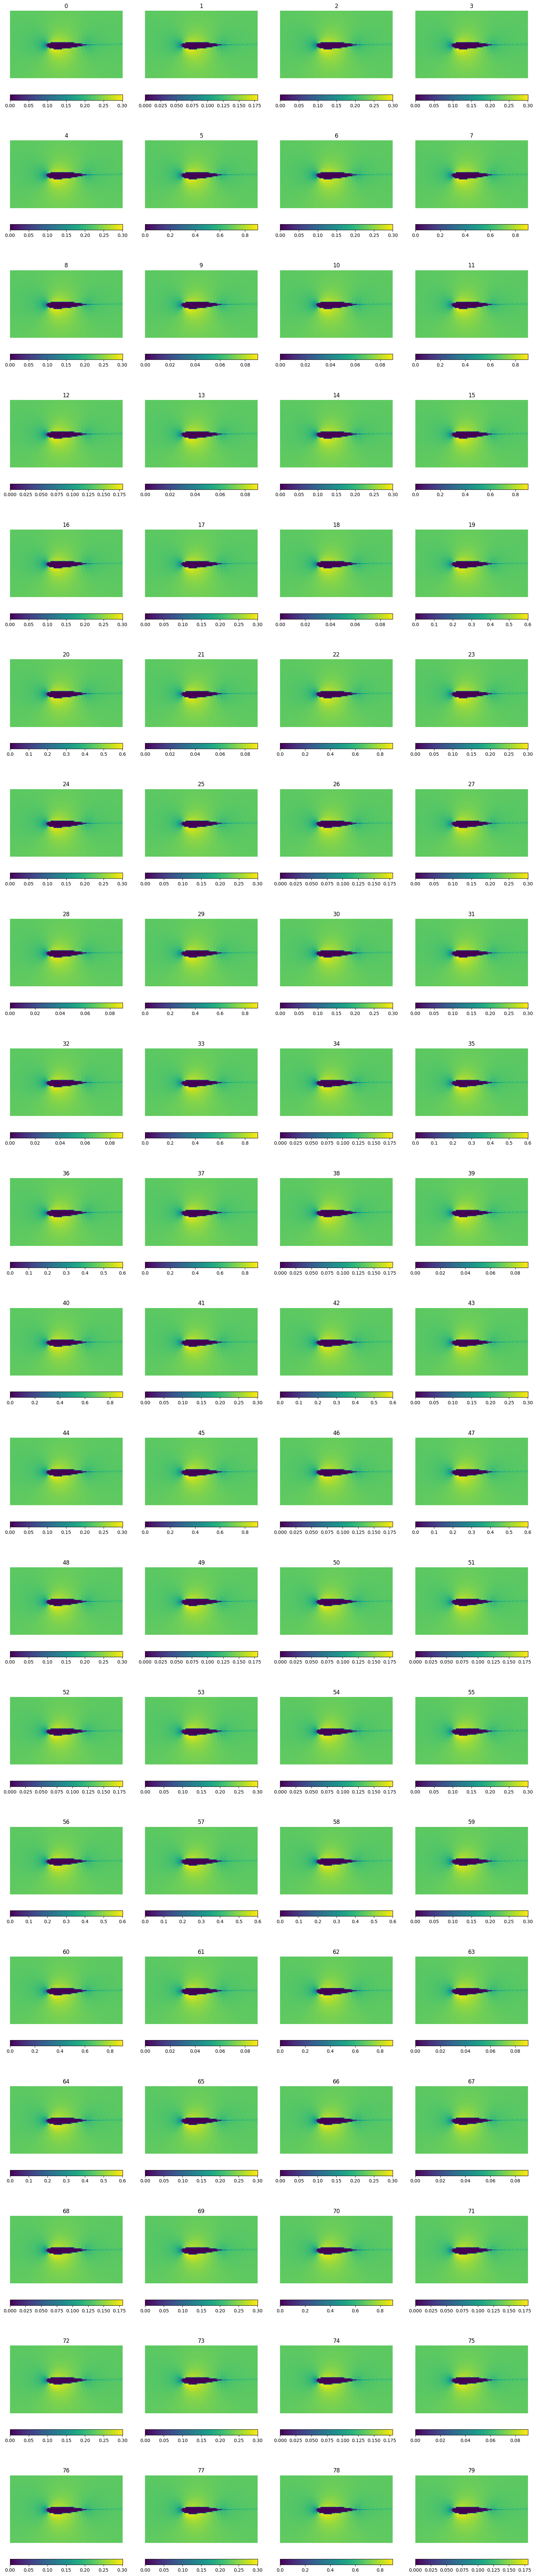

In [75]:
[a,b,c,d]=label_train.shape
fig = plt.figure(figsize=(20, 100))
columns = 4
rows = 20
print(rows)

for i in range( columns * rows):
    img = label_train[(i-1),:,:,0]
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img,extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
    plt.title(i)
    plt.axis('off')
    plt.colorbar(location='bottom')

plt.show()

In [31]:
# Valid for input with four layers
model = models.Sequential()
model.add(layers.Conv2D(16,( 4,12), (2, 8), activation='tanh',padding="same", input_shape=(66,256, l-1)))
model.add(layers.Conv2D(64,(6), (3, 4), activation='tanh',padding="same",))
model.add(layers.Conv2D(256,(16,12), (11, 8), activation='tanh',padding="same",))
model.add(layers.Conv2DTranspose(32,(14,10),(11,8), activation='tanh',padding="same"))
model.add(layers.Conv2DTranspose(16,(6,8),(3,4), activation='tanh',padding="same"))
model.add(layers.Conv2DTranspose(l-1,(4,16),(2,8), activation='linear', padding="same"))

In [32]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 33, 32, 16)        2320      
                                                                 
 conv2d_4 (Conv2D)           (None, 11, 8, 64)         36928     
                                                                 
 conv2d_5 (Conv2D)           (None, 1, 1, 256)         3145984   
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 11, 8, 32)        1146912   
 ranspose)                                                       
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 33, 32, 16)       24592     
 ranspose)                                                       
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 66, 256, 3)      

In [33]:
model.compile(optimizer='adam',
              loss='mse')

In [34]:
folders=os.listdir('training/')
print(folders)
sub='training_'
folders = [x for x in folders if re.search(sub, x)]
#print(len(folders))
if len(folders)==0:
    filefolder=sub+'0'
else:
    id=[]
    for txt in folders:
        t=txt.split('_')
        id.append(int(t[len(t)-1]))
    index_max=np.argmax(id)
    filefolder= sub+str(id[index_max]+1)
print(filefolder)

['training_0', 'training_1', 'training_2', 'training_3', 'training_4', 'training_5', 'training_6', 'training_7']
training_8


In [35]:
filepath ='training/'+ filefolder+'/'+'vae_best_model_relu.epoch{epoch:02d}-loss{loss:.5f}.w'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='loss',
                             verbose=1,
                             save_weights_only=True,
                             save_best_only=True,
                             mode='min')
callbacks = [checkpoint]

In [36]:
history = model.fit(train_data, label_train, epochs=100, 
                    validation_data=(test_data, label_test),
                    batch_size=32,
                   callbacks=callbacks)

Epoch 1/100
61/61 [==============================] - ETA: 0s - loss: 0.0104
Epoch 1: loss improved from inf to 0.01041, saving model to training/training_8\vae_best_model_relu.epoch01-loss0.01041.w
61/61 [==============================] - 17s 262ms/step - loss: 0.0104 - val_loss: 0.0014
Epoch 2/100
61/61 [==============================] - ETA: 0s - loss: 8.4593e-04
Epoch 2: loss improved from 0.01041 to 0.00085, saving model to training/training_8\vae_best_model_relu.epoch02-loss0.00085.w
61/61 [==============================] - 16s 262ms/step - loss: 8.4593e-04 - val_loss: 6.7876e-04
Epoch 3/100
61/61 [==============================] - ETA: 0s - loss: 5.0990e-04
Epoch 3: loss improved from 0.00085 to 0.00051, saving model to training/training_8\vae_best_model_relu.epoch03-loss0.00051.w
61/61 [==============================] - 16s 265ms/step - loss: 5.0990e-04 - val_loss: 6.5279e-04
Epoch 4/100
61/61 [==============================] - ETA: 0s - loss: 6.8768e-04
Epoch 4: loss did not im

61/61 [==============================] - ETA: 0s - loss: 4.3347e-05
Epoch 31: loss did not improve from 0.00003
61/61 [==============================] - 14s 237ms/step - loss: 4.3347e-05 - val_loss: 1.0296e-04
Epoch 32/100
61/61 [==============================] - ETA: 0s - loss: 2.4596e-05
Epoch 32: loss improved from 0.00003 to 0.00002, saving model to training/training_8\vae_best_model_relu.epoch32-loss0.00002.w
61/61 [==============================] - 15s 250ms/step - loss: 2.4596e-05 - val_loss: 7.9636e-05
Epoch 33/100
61/61 [==============================] - ETA: 0s - loss: 4.1858e-05
Epoch 33: loss did not improve from 0.00002
61/61 [==============================] - 15s 243ms/step - loss: 4.1858e-05 - val_loss: 1.0100e-04
Epoch 34/100
61/61 [==============================] - ETA: 0s - loss: 5.6671e-05
Epoch 34: loss did not improve from 0.00002
61/61 [==============================] - 14s 237ms/step - loss: 5.6671e-05 - val_loss: 1.0670e-04
Epoch 35/100
61/61 [==================

61/61 [==============================] - ETA: 0s - loss: 0.0129
Epoch 69: loss did not improve from 0.00002
61/61 [==============================] - 15s 237ms/step - loss: 0.0129 - val_loss: 0.0132
Epoch 70/100
61/61 [==============================] - ETA: 0s - loss: 0.0128
Epoch 70: loss did not improve from 0.00002
61/61 [==============================] - 15s 240ms/step - loss: 0.0128 - val_loss: 0.0132
Epoch 71/100
61/61 [==============================] - ETA: 0s - loss: 0.0128
Epoch 71: loss did not improve from 0.00002
61/61 [==============================] - 14s 237ms/step - loss: 0.0128 - val_loss: 0.0133
Epoch 72/100
61/61 [==============================] - ETA: 0s - loss: 0.0129
Epoch 72: loss did not improve from 0.00002
61/61 [==============================] - 15s 240ms/step - loss: 0.0129 - val_loss: 0.0133
Epoch 73/100
61/61 [==============================] - ETA: 0s - loss: 0.0129
Epoch 73: loss did not improve from 0.00002
61/61 [==============================] - 15s 241

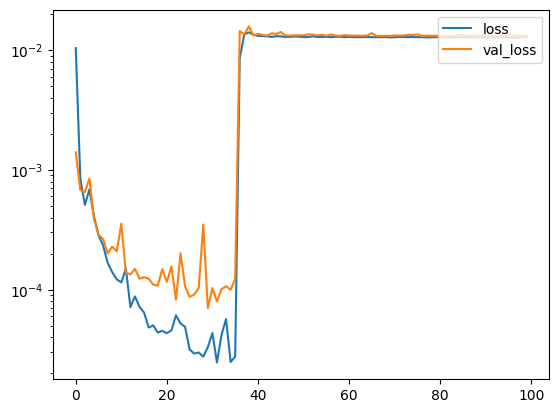

In [37]:
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
#plt.xlabel('Epoch')
#plt.ylabel('loss')
#plt.ylim([0.5, 1])
plt.yscale('log')
plt.legend(loc='upper right')

Finding the last epoch in the training folder

In [38]:
#filefolder= 'training_6'

folders=os.listdir('training/'+filefolder)
#folders=os.listdir('training/'+'training_0/')

sub='index'
folders = [x for x in folders if re.search(sub, x)]

ts=[]
for folder in folders:
    a=re.search('\d{2,3}',folder)
    ts.append(int(a.group(0)))
    #print(a.group(0))
index_max=np.max(ts)
print(index_max)
latest = [x for x in folders if re.search(str(index_max), x)]

latest=latest[0].split('.index')
print(latest[0])

32
vae_best_model_relu.epoch32-loss0.00002.w


In [39]:
weights_path='training/'+filefolder+'/'+latest[0]

#weights_path='training/'+'training_0'+'/'+latest[0]

print(weights_path)
model.load_weights(weights_path)

training/training_8/vae_best_model_relu.epoch32-loss0.00002.w


In [40]:
test=model.predict(test_data)

11/11 [==============================] - 1s 42ms/step


In [41]:
print(label_test.shape[0])
n=0
print('max:' , np.max(test[:,:,:,n]))
print('min:' , np.min(test[:,:,:,n]))
#label_test=label_test.reshape((36,66,256,4))
#plt.imshow(np.clip(label_test[1,:,:,3],0,1))

345
max: 0.9807865
min: -0.18875083


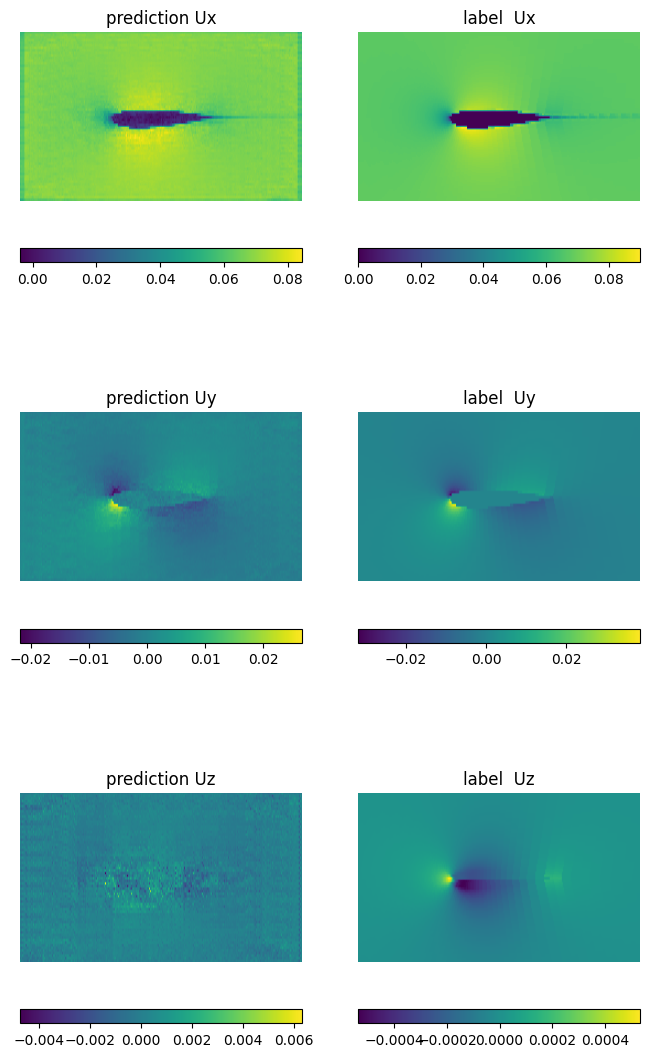

In [42]:
n=23
fig = plt.figure(figsize=(8, 14))
[a,b,c,d]=test.shape
titles= ['Ux','Uy','Uz','p']

for i in range(d):
    fig.add_subplot(d, 2, i*2+1)
    plt.imshow(test[n,:,:,i],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
    plt.title('prediction ' +titles[i])
    plt.axis('off')
    plt.colorbar(location='bottom')
    
    fig.add_subplot(d, 2, i*2+2)
    plt.imshow(label_test[n,:,:,i],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
    plt.title('label  '+titles[i])
    plt.axis('off')
    plt.colorbar(location='bottom')
    #print(i)

plt.show()

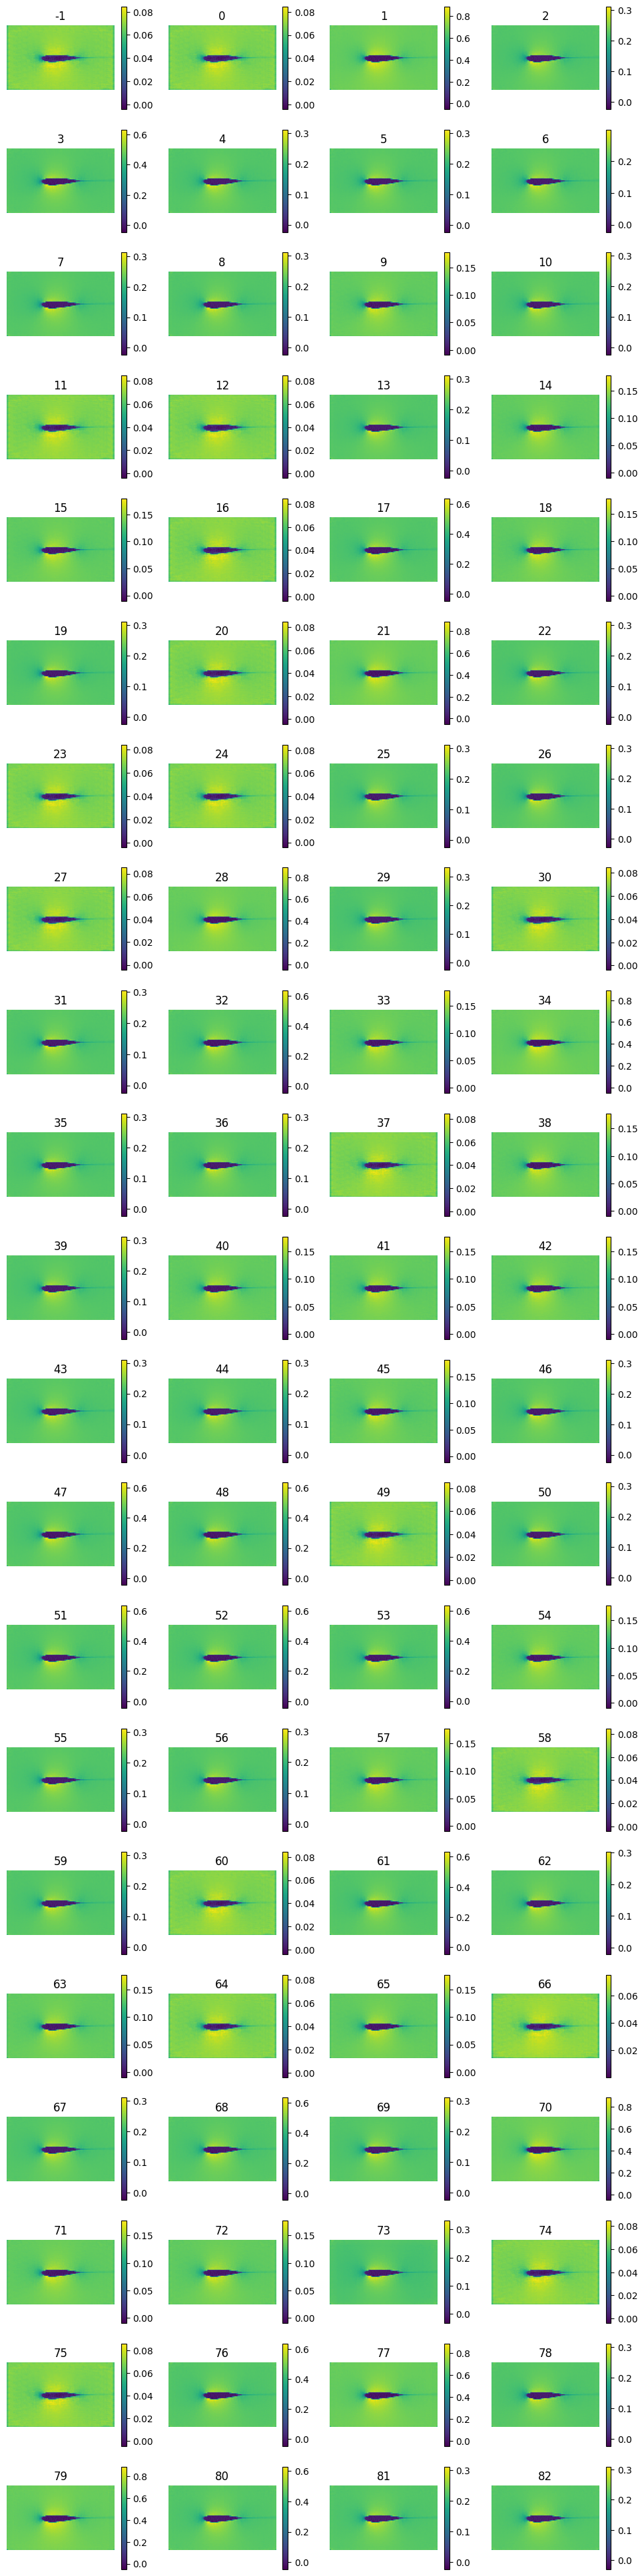

In [43]:
[a,b,c,d]=test.shape
fig = plt.figure(figsize=(12, 50))
columns = 4
rows = 21

for i in range( columns * rows):
    img = test[(i-1),:,:,0]
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img,extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
    plt.title(i-1)
    plt.axis('off')
    plt.colorbar()
plt.show()

In [57]:
mse=[]
ssim1=[]
for i in range(label_test.shape[0]):
    mse.append(mean_squared_error(test[i,:,:,3],label_test[i,:,:,3]))
    ssim1.append(ssim(test[i,:,:,3],label_test[i,:,:,3]))
print('max mse:'+ str(max(mse)))
print(ssim1[n])
print(mse[n])
mse=np.mean(mse)
ssim2=np.mean(ssim1[:])
print('average ssim: '+str(ssim2))
print('average mse: '+str(mse))

C:\Users\hansi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\skimage\_shared\utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


max mse:0.004268981377960514
0.1615901839459936
0.002357455493213041
average ssim: 0.1640604946376105
average mse: 0.002592235416306115


In [43]:
#os.mkdir('cfdnetplus_models')
model.save('cfdnetplus_models/'+modelid)

INFO:tensorflow:Assets written to: cfdnetplus_models/model1\assets


INFO:tensorflow:Assets written to: cfdnetplus_models/model1\assets
